# Four Multiplets (SI Figure 6)

## Defining the Experiment Info

In [1]:
import nmrespy as ne

offset = 0.0  # Hz
sw1 = 40.0  # Hz
sw2 = 1000.0  # Hz
pts1 = 128
pts2 = 8192
sfo = 500.0  # MHz
nucleus = "1H"

expinfo = ne.ExpInfo(
    dim=2,
    sw=(sw1, sw2),
    offset=(0., offset),
    pts=(pts1, pts2),
    sfo=(None, sfo),
    nuclei=(None, nucleus),
)

## Path Declarations

In [2]:
from pathlib import Path
import re

root = Path("../..")
name = "four-multiplets"
data_dir = root / "data" / name / "datasets"
output_dir = root / "code" / name / "output"

estimator_path_tmpl = str(output_dir / "estimator_{}.pkl")
output_dir.mkdir(exist_ok=True, parents=True)

data_paths = [str(p) for p in data_dir.iterdir() if p.suffix == ".mat"]
estimator_paths = [
    estimator_path_tmpl.format(re.search(r"dataset_(\d+)\.mat$", p).group(1))
    for p in data_paths
]

## Creating and Saving the Estimator Objects

In [3]:
import copy
import numpy as np
from scipy.io import loadmat

estimators = []
for data_path, estimator_path in zip(data_paths, estimator_paths):
    if Path(estimator_path).is_file():
        estimator = ne.Estimator2DJ.from_pickle(estimator_path)
    else: 
        fid = loadmat(data_path)["fid"].T
        # Add AWGN to with target SNR of 30 dB.
        fid = ne.sig.add_noise(fid, 40.0)
        # Create NMR-EsPy 2DJ estimatior object containing the FID and the experiment info.
        estimator = ne.Estimator2DJ(fid, copy.deepcopy(expinfo))
        # Apply some exponential apodisation in the direct dimension
        estimator._data = ne.sig.exp_apodisation(estimator._data, 4.0, axes=[0])
        estimator._data = ne.sig.exp_apodisation(estimator._data, 6.0, axes=[1])
        # Spianch output is 90° phase shifted in the direct dimension. This needs to be corrected.
        estimator.phase_data(p0=0.5 * np.pi, p1=0.)
        estimator.to_pickle(estimator_path, force_overwrite=True)
    estimators.append(estimator)

## Estimation

In [4]:
np.random.seed(0)

estimate_kwargs = dict(
    region=(35.0, -35.0),
    noise_region=(-400.0, -350.0),
    region_unit="hz",
    initial_guess=36,
    max_iterations=250,
)

rerun_estimation = False
for estimator, path in zip(estimators, estimator_paths):
    try:
        if rerun_estimation:
            estimator._results = []
            raise ValueError("Re-running estimation.")
        estimator.get_results()
    except ValueError:
        estimator.estimate(**estimate_kwargs)
        estimator.to_pickle(path, force_overwrite=True)

## Removing Spurious Signals

In [7]:
for estimator in estimators:
    estimator.predict_multiplets(rm_spurious=True)

## Displaying the Results

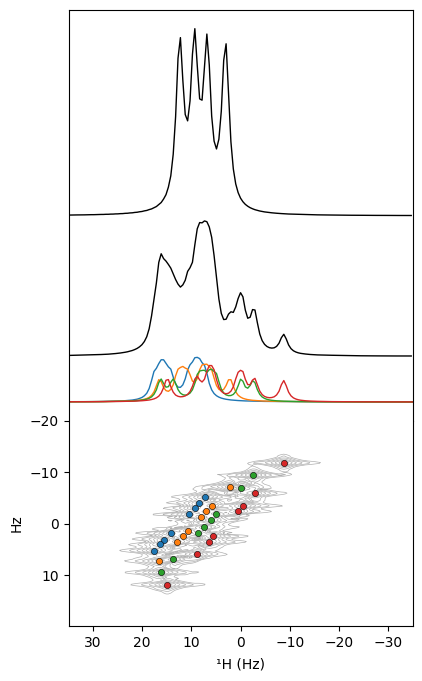

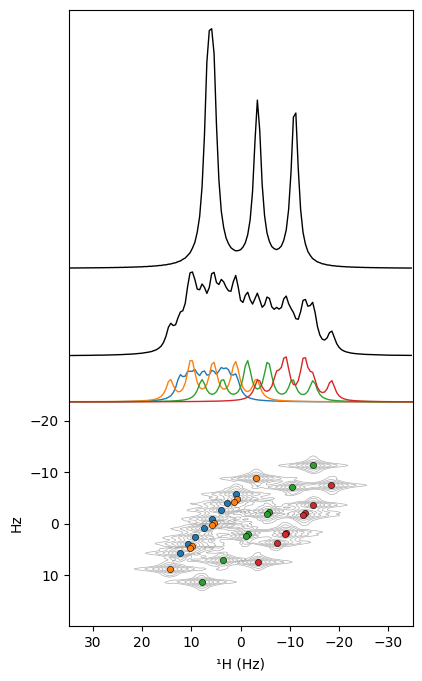

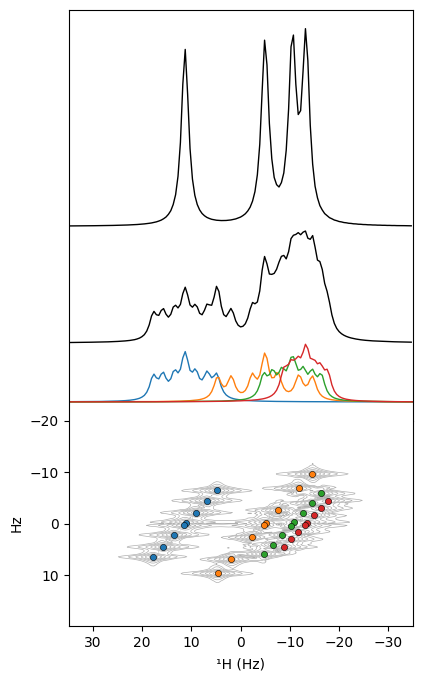

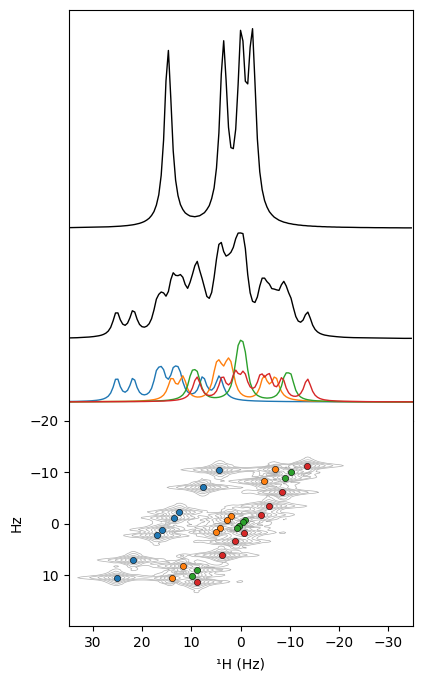

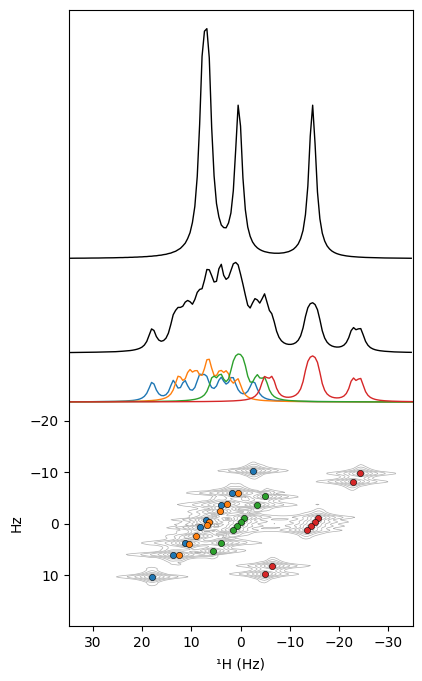

In [11]:
import matplotlib.pyplot as plt

plot_kwargs = dict(
    marker_size=20.0,
    contour_base=0.7,
    contour_factor=2.0,
    contour_nlevels=15,
    contour_color="#b0b0b0",
    figsize=(4.0, 7.0),
    multiplet_show_45=False,
    multiplet_show_center_freq=False,
    axes_left=0.1,
)

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
figs = []
for estimator in estimators:
    figs.append(estimator.plot_result(**plot_kwargs, multiplet_colors=colors))

In [9]:
estimators[0].predict_multiplets()

{np.float64(3.0444026618999933): [0, 1, 3, 5, 8, 11, 18, 27],
 np.float64(6.7785301103375595): [2, 4, 7, 10, 14, 17, 25, 29],
 np.float64(9.35289676552406): [6, 9, 12, 15, 21, 22, 24, 31],
 np.float64(12.354422616016286): [13, 16, 19, 20, 26, 28, 30, 32],
 np.float64(24.818040956868263): [23],
 np.float64(33.157897246154604): [33]}